# Weather Temperature

In [30]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os

# Deep Learning
import tensorflow as tf
from keras import models, layers, Input, optimizers, metrics
from keras.regularizers import L1L2
from keras.layers import Normalization, Lambda
from keras.callbacks import EarlyStopping

In [2]:
from typing import Dict, List, Tuple, Sequence

## (0) The weather temperature challenge

### (0.1) The weather dataset

In [3]:
url = "https://wagon-public-datasets.s3.amazonaws.com/deep_learning_datasets/weather_every_three_hours_engineered.csv"
df = pd.read_csv(url).drop(columns = ['Unnamed: 0'])
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day_sin,Day_cos,Year_sin,Year_cos
0,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,7.071068e-01,7.071068e-01,0.011483,0.999934
1,997.71,-9.67,263.66,-10.62,92.70,2.93,2.71,0.21,1.69,2.72,1317.71,-0.041452,0.027960,-0.414519,0.279596,1.000000e+00,4.339955e-12,0.013633,0.999907
2,999.69,-7.66,265.52,-8.84,91.20,3.43,3.13,0.30,1.95,3.13,1310.14,-0.314796,-0.128466,-0.583298,-0.238040,7.071068e-01,-7.071068e-01,0.015783,0.999875
3,1000.30,-6.87,266.27,-8.28,89.60,3.64,3.27,0.38,2.03,3.26,1306.98,-1.834577,-0.141163,-2.622249,-0.201771,6.903299e-12,-1.000000e+00,0.017933,0.999839
4,999.88,-5.69,267.48,-7.00,90.40,3.99,3.61,0.38,2.25,3.61,1300.51,-0.825870,0.828758,-1.327039,1.331679,-7.071068e-01,-7.071068e-01,0.020083,0.999798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23358,1006.23,-6.31,266.37,-8.42,84.90,3.81,3.23,0.57,2.00,3.21,1312.01,-1.279930,-0.013404,-1.839899,-0.019268,6.755902e-01,-7.372773e-01,-0.000268,1.000000
23359,1004.62,-0.71,272.09,-5.97,67.37,5.80,3.91,1.89,2.42,3.89,1282.65,-0.976457,-0.412471,-1.916066,-0.809378,-4.361939e-02,-9.990482e-01,0.001883,0.999998
23360,1003.09,4.97,277.88,-3.04,56.03,8.71,4.88,3.83,3.03,4.86,1254.09,-0.403185,-0.359224,-0.776504,-0.691840,-7.372773e-01,-6.755902e-01,0.004033,0.999992
23361,1002.27,-0.42,272.56,-4.92,71.50,5.92,4.23,1.69,2.63,4.22,1278.14,-0.266024,-0.350473,-0.604599,-0.796530,-9.990482e-01,4.361939e-02,0.006183,0.999981


In [4]:
# Let's define the global variables of our dataset
TARGET = 'T (degC)'
N_TARGETS = 1
N_FEATURES = 19

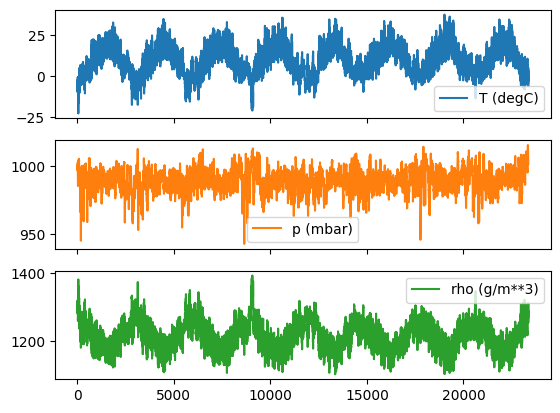

In [5]:
plot_cols = [TARGET, 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

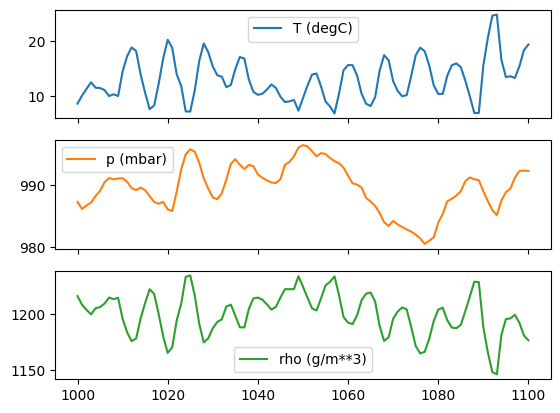

In [6]:
zoomed_slice = slice(1000,1100)

plot_features = df.loc[zoomed_slice, plot_cols]
plot_features.plot(subplots = True);

## (1) Prepare the dataset

In [7]:
FOLD_LENGTH = 8*365 * 3 # every 3 hrs x 8 = 24h
                        # three years

FOLD_STRIDE = 8*91 # every 3 hrs x 8 = 24h
                   # 1 quarter = 91 days

TRAIN_TEST_RATIO = 0.66

In [9]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int) -> List[pd.DataFrame]:
    """
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Args:
        df (pd.DataFrame): Overall dataframe
        fold_length (int): How long each fold should be in rows
        fold_stride (int): How many timesteps to move forward between taking each fold

    Returns:
        List[pd.DataFrame]: A list where each fold is a dataframe within
    """

    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

In [10]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 21 folds.
Each fold has a shape equal to (8760, 19).


In [11]:
fold = folds[0]
fold

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day_sin,Day_cos,Year_sin,Year_cos
0,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,7.071068e-01,7.071068e-01,0.011483,0.999934
1,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,-0.041452,0.027960,-0.414519,0.279596,1.000000e+00,4.339955e-12,0.013633,0.999907
2,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,-0.314796,-0.128466,-0.583298,-0.238040,7.071068e-01,-7.071068e-01,0.015783,0.999875
3,1000.30,-6.87,266.27,-8.28,89.6,3.64,3.27,0.38,2.03,3.26,1306.98,-1.834577,-0.141163,-2.622249,-0.201771,6.903299e-12,-1.000000e+00,0.017933,0.999839
4,999.88,-5.69,267.48,-7.00,90.4,3.99,3.61,0.38,2.25,3.61,1300.51,-0.825870,0.828758,-1.327039,1.331679,-7.071068e-01,-7.071068e-01,0.020083,0.999798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,980.34,1.45,276.18,0.03,90.2,6.79,6.12,0.67,3.89,6.24,1240.67,-0.604351,-3.731375,-1.191115,-7.354165,-8.715574e-02,-9.961947e-01,-0.028744,0.999587
8756,983.25,2.23,276.73,0.21,86.4,7.18,6.20,0.98,3.93,6.31,1240.81,-0.432628,-2.126437,-0.849307,-4.174479,-7.660444e-01,-6.427876e-01,-0.026594,0.999646
8757,985.46,1.69,276.00,-0.52,85.2,6.90,5.88,1.02,3.72,5.97,1246.23,-0.626578,-2.513066,-0.977364,-3.919995,-9.961947e-01,8.715574e-02,-0.024445,0.999701
8758,986.63,2.16,276.38,-1.14,78.7,7.14,5.62,1.52,3.55,5.70,1245.68,-0.773266,-3.669409,-1.222791,-5.802558,-6.427876e-01,7.660444e-01,-0.022295,0.999751


In [12]:
INPUT_LENGTH = 8 * 14 # records every 3 hours x 8 = 24 hours
                      # two weeks

In [13]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    """From a fold dataframe, take a train dataframe and test dataframe based on
    the split ratio.
    - df_train should contain all the timesteps until round(train_test_ratio * len(fold))
    - df_test should contain all the timesteps needed to create all (X_test, y_test) tuples

    Args:
        fold (pd.DataFrame): A fold of timesteps
        train_test_ratio (float): The ratio between train and test 0-1
        input_length (int): How long each X_i will be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (fold_train, fold_test)
    """

    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [14]:
TRAIN_TEST_RATIO

0.66

In [15]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

In [16]:
# INPUT X
print(f'N_FEATURES = {N_FEATURES}')
print(f'INPUT_LENGTH = {INPUT_LENGTH} timesteps = {int(INPUT_LENGTH/8)} days = {int(INPUT_LENGTH/8/7)} weeks')

N_FEATURES = 19
INPUT_LENGTH = 112 timesteps = 14 days = 2 weeks


In [18]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


In [19]:
def get_Xi_yi(
    fold:pd.DataFrame,
    input_length:int,
    output_length:int) -> Tuple[pd.DataFrame]:
    """given a fold, it returns one sequence (X_i, y_i) as based on the desired
    input_length and output_length with the starting point of the sequence being chosen at random based

    Args:
        fold (pd.DataFrame): A single fold
        input_length (int): How long each X_i should be
        output_length (int): How long each y_i should be

    Returns:
        Tuple[pd.DataFrame]: A tuple of two dataframes (X_i, y_i)
    """
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]

    return (X_i, y_i)

In [20]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

In [21]:
# Advanced check 😈
# You should not allow some truncated (X_i,y_i) pairs to be generating,
# should you start sampling too close from the end of the fold... !

X_last, y_last = get_Xi_yi(fold_test, input_length=len(fold_test)-1, output_length=OUTPUT_LENGTH)
assert y_last.values == fold_test.iloc[-1,:][TARGET]

In [22]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int) -> Tuple[np.array]:
    """Given a fold generate X and y based on the number of desired sequences
    of the given input_length and output_length

    Args:
        fold (pd.DataFrame): Fold dataframe
        number_of_sequences (int): The number of X_i and y_i pairs to include
        input_length (int): Length of each X_i
        output_length (int): Length of each y_i

    Returns:
        Tuple[np.array]: A tuple of numpy arrays (X, y)
    """
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)

    return np.array(X), np.array(y)

In [23]:
N_TRAIN = 6666 # number_of_sequences_train
N_TEST =  3333 # number_of_sequences_test

X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

## (2) Modeling

In [25]:
def init_model(X_train, y_train):
    # 0 - Normalization
    # ======================
    normalizer = Normalization()
    normalizer.adapt(X_train)

    # 1 - RNN architecture
    # ======================
    model = models.Sequential()
    model.add(Input(shape=X_train[0].shape))
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64,
                          activation='tanh',
                          return_sequences = False,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================
    adam = optimizers.Adam(learning_rate=0.005)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

model = init_model(X_train, y_train)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 112, 19)        │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,608 (84.41 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 39 (160.00 B)

In [26]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS:MAE ---

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

In [28]:
def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:
    es = EarlyStopping(monitor = "val_loss",
                      patience = 10,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history

In [29]:
model = init_model(X_train, y_train)
model.summary()

model, history = fit_model(model)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 112, 19)        │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,608 (84.41 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 39 (160.00 B)

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 26.1226 - mae: 2.7855 - val_loss: 8.2634 - val_mae: 1.6859
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 6.2668 - mae: 1.4979 - val_loss: 5.4256 - val_mae: 1.4214
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 4.6730 - mae: 1.3213 - val_loss: 4.3636 - val_mae: 1.2836
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 4.0291 - mae: 1.2236 - val_loss: 3.8371 - val_mae: 1.1824
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 3.7671 - mae: 1.1830 - val_loss: 3.6873 - val_mae: 1.1668
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 3.6018 - mae: 1.1574 - val_loss: 3.8600 - val_mae: 1.2209
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 3.4938 - mae: 1.1406 - val_loss: 3.5426 - val_mae: 1.1596
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 3.3329 - mae: 1.1090 - val_loss: 3.4312 - val_mae: 1.1361
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms

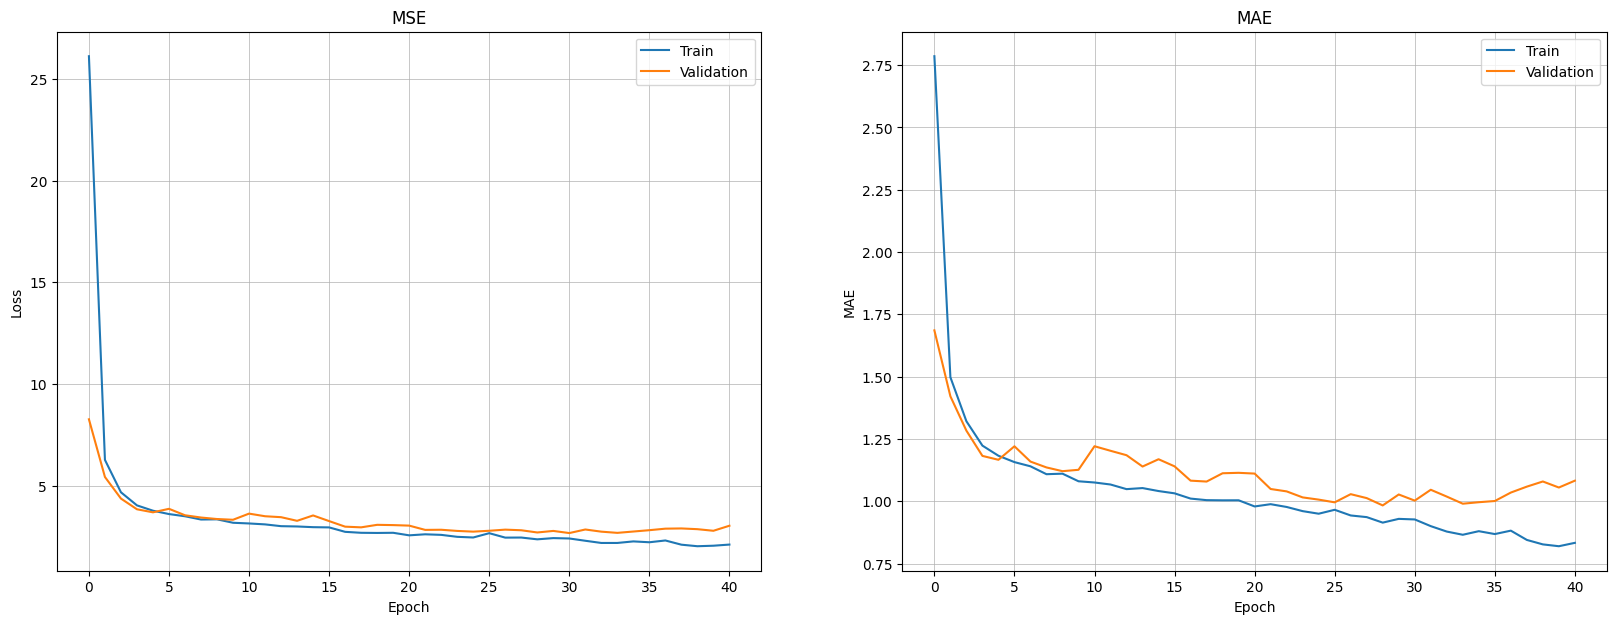

In [31]:
plot_history(history);

In [32]:
# 3 - Evaluation
# ====================================
res = model.evaluate(X_test, y_test)
print(f"The LSTM MAE on the test set is equal to {round(res[1],2)} Celsius degrees")

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3833 - mae: 1.1897
The LSTM MAE on the test set is equal to 1.19 Celsius degrees


### (2.2) A Baseline Model to compare our LSTM with!

In [33]:
def init_baseline():
    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model

baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} Celsius degrees")


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.1409 - mae: 2.1029
- The Baseline MAE on the test set is equal to 2.1 Celsius degrees


In [34]:
print(f"- The LSTM MAE on the test set is equal to {round(res[1],2)} Celsius degrees")
print(f"🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} % 🔥")

- The LSTM MAE on the test set is equal to 1.19 Celsius degrees
🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : 43.42 % 🔥


### (2.3) Cross-Validation

In [35]:
# Reminders of the global variables in this notebook

print(f'N_FEATURES = {N_FEATURES}')
print(f'N_TARGETS = {N_TARGETS}')
print('')
print(f'FOLD_LENGTH = {FOLD_LENGTH}')
print(f'FOLD_STRIDE = {FOLD_STRIDE}')
print(f'TRAIN_TEST_RATIO = {TRAIN_TEST_RATIO}')
print('')
print(f'N_TRAIN = {N_TRAIN}')
print(f'N_TEST = {N_TEST}')
print(f'INPUT_LENGTH = {INPUT_LENGTH}')
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_FEATURES = 19
N_TARGETS = 1

FOLD_LENGTH = 8760
FOLD_STRIDE = 728
TRAIN_TEST_RATIO = 0.66

N_TRAIN = 6666
N_TEST = 3333
INPUT_LENGTH = 112
OUTPUT_LENGTH = 1


In [36]:
# Remember how many folds do we have ?
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f"WARNING, we have {len(folds)} FOLDS, so you may want to run the cross-validation of the RNN on Colab.")

WARNING, we have 21 FOLDS, so you may want to run the cross-validation of the RNN on Colab.


In [37]:
def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates
    - the "last seen value" baseline model
    - the RNN model
    '''

    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []

    # 0 - Creating folds
    # =========================================
    folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

    for fold_id, fold in enumerate(folds):

        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

        X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
        X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

        # 2 - Modelling
        # =========================================

        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 2,
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")

        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [ ]:
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

In [ ]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")